# Import libraries

In [111]:
import os
import gc
import re
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import (
    roc_auc_score, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score
)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import yfinance as yf
import ta
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import math
import pandas_datareader as web
from keras.models import Sequential
from keras.layers import Dense, LSTM
import pandas as pd
import datetime as dt
import bs4 as bs
import requests
from IPython.display import clear_output
from scipy.stats import mstats
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import RandomizedSearchCV, validation_curve, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pickle
import talib

sns.set()

warnings.filterwarnings("ignore")


# Get basket of stocks

In [112]:
tickers = [
    "BTC-USD",  # Bitcoin
    "XMR-USD",  # Monero
    "DAI-USD",  # Dai
    "AAVE-USD", # Aave
    "DOT-USD",  # Polkadot
    "CRV-USD",  # Curve DAO Token
    "LTC-USD",  # Litecoin
    "SOL-USD",  # Solana
    "UNI-USD",  # Uniswap
    "TRX-USD",  # TRON
    "BNB-USD",  # BNB
    "ADA-USD",  # Cardano
    "EOS-USD",  # EOS
    "DOGE-USD", # Dogecoin
    "MATIC-USD", # Polygon
    "ETH-USD"
]

ticker = "BTC-USD"
start_date = "2020-01-01"

all_data = pd.DataFrame()
test_data = pd.DataFrame()
no_data = []

for i in tickers:
    try:
        print(i)
        test_data = yf.download(i, start="2020-01-01", interval='1d') 
        test_data['symbol'] = i
        all_data = pd.concat([all_data, test_data])
        
    except:
        no_data.append(i)

all_data.tail()

BTC-USD
[*********************100%%**********************]  1 of 1 completed
XMR-USD
[*********************100%%**********************]  1 of 1 completed
DAI-USD
[*********************100%%**********************]  1 of 1 completed
AAVE-USD
[*********************100%%**********************]  1 of 1 completed
DOT-USD
[*********************100%%**********************]  1 of 1 completed
CRV-USD
[*********************100%%**********************]  1 of 1 completed
LTC-USD
[*********************100%%**********************]  1 of 1 completed
SOL-USD
[*********************100%%**********************]  1 of 1 completed
UNI-USD
[*********************100%%**********************]  1 of 1 completed
TRX-USD
[*********************100%%**********************]  1 of 1 completed
BNB-USD
[*********************100%%**********************]  1 of 1 completed
ADA-USD
[*********************100%%**********************]  1 of 1 completed
EOS-USD
[*********************100%%**********************]  1 of 1 complete

,Open,High,Low,Close,Adj Close,Volume,symbol
Date,,,,,,,
2023-11-17,1961.8676,1990.0505,1910.4454,1961.2808,1961.2808,11881648738,ETH-USD
2023-11-18,1961.6713,1971.4623,1921.0624,1963.2850,1963.2850,8064677046,ETH-USD
2023-11-19,1963.1801,2015.6339,1944.9009,2013.2045,2013.2045,7716048818,ETH-USD
2023-11-20,2011.8534,2066.4099,1996.0443,2022.2391,2022.2391,12866464824,ETH-USD
2023-11-21,2022.2173,2034.9540,2020.2212,2023.9377,2023.9377,12821187584,ETH-USD


In [113]:
all_data.tail()

,Open,High,Low,Close,Adj Close,Volume,symbol
Date,,,,,,,
2023-11-17,1961.8676,1990.0505,1910.4454,1961.2808,1961.2808,11881648738,ETH-USD
2023-11-18,1961.6713,1971.4623,1921.0624,1963.2850,1963.2850,8064677046,ETH-USD
2023-11-19,1963.1801,2015.6339,1944.9009,2013.2045,2013.2045,7716048818,ETH-USD
2023-11-20,2011.8534,2066.4099,1996.0443,2022.2391,2022.2391,12866464824,ETH-USD
2023-11-21,2022.2173,2034.9540,2020.2212,2023.9377,2023.9377,12821187584,ETH-USD


# Creating return column for each symbol 

In [114]:
#Creating Return column
all_data['return'] = all_data.groupby('symbol')['Close'].pct_change()
all_data.tail()

,Open,High,Low,Close,Adj Close,Volume,symbol,return
Date,,,,,,,,
2023-11-17,1961.8676,1990.0505,1910.4454,1961.2808,1961.2808,11881648738,ETH-USD,0.0002
2023-11-18,1961.6713,1971.4623,1921.0624,1963.2850,1963.2850,8064677046,ETH-USD,0.0010
2023-11-19,1963.1801,2015.6339,1944.9009,2013.2045,2013.2045,7716048818,ETH-USD,0.0254
2023-11-20,2011.8534,2066.4099,1996.0443,2022.2391,2022.2391,12866464824,ETH-USD,0.0045
2023-11-21,2022.2173,2034.9540,2020.2212,2023.9377,2023.9377,12821187584,ETH-USD,0.0008


In [115]:
# Now, we will be calculating TAs

# SMA
all_data['SMA_5'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.rolling(window = 5).mean())
all_data['SMA_15'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.rolling(window = 15).mean())
all_data['SMA_ratio'] = all_data['SMA_15'] / all_data['SMA_5']

# SMA volume
all_data['SMA5_Volume'] = all_data.groupby('symbol')['Volume'].transform(lambda x: x.rolling(window = 5).mean())
all_data['SMA15_Volume'] = all_data.groupby('symbol')['Volume'].transform(lambda x: x.rolling(window = 15).mean())
all_data['SMA_Volume_Ratio'] = all_data['SMA5_Volume']/all_data['SMA15_Volume']

# Wilder smoothing for smoothing out values
def Wilder(data, periods):
    start = np.where(~np.isnan(data))[0][0] #Check if nans present in beginning
    Wilder = np.array([np.nan]*len(data))
    Wilder[start+periods-1] = data[start:(start+periods)].mean() #Simple Moving Average
    for i in range(start+periods,len(data)):
        Wilder[i] = (Wilder[i-1]*(periods-1) + data[i])/periods #Wilder Smoothing
    return(Wilder)

# ATR
all_data['prev_close'] = all_data.groupby('symbol')['Close'].shift(1)
all_data['TR'] = np.maximum((all_data['High'] - all_data['Low']), 
                     np.maximum(abs(all_data['High'] - all_data['prev_close']), 
                     abs(all_data['prev_close'] - all_data['Low'])))
for i in all_data['symbol'].unique():
    TR_data = all_data[all_data.symbol == i].copy()
    all_data.loc[all_data.symbol==i,'ATR_5'] = Wilder(TR_data['TR'], 5)
    all_data.loc[all_data.symbol==i,'ATR_15'] = Wilder(TR_data['TR'], 15)

all_data['ATR_Ratio'] = all_data['ATR_5'] / all_data['ATR_15']

# ADX 
all_data['prev_high'] = all_data.groupby('symbol')['High'].shift(1)
all_data['prev_low'] = all_data.groupby('symbol')['Low'].shift(1)

all_data['+DM'] = np.where(~np.isnan(all_data.prev_high),
                           np.where((all_data['High'] > all_data['prev_high']) & 
         (((all_data['High'] - all_data['prev_high']) > (all_data['prev_low'] - all_data['Low']))), 
                                                                  all_data['High'] - all_data['prev_high'], 
                                                                  0),np.nan)

all_data['-DM'] = np.where(~np.isnan(all_data.prev_low),
                           np.where((all_data['prev_low'] > all_data['Low']) & 
         (((all_data['prev_low'] - all_data['Low']) > (all_data['High'] - all_data['prev_high']))), 
                                    all_data['prev_low'] - all_data['Low'], 
                                    0),np.nan)

for i in all_data['symbol'].unique():
    ADX_data = all_data[all_data.symbol == i].copy()
    all_data.loc[all_data.symbol==i,'+DM_5'] = Wilder(ADX_data['+DM'], 5)
    all_data.loc[all_data.symbol==i,'-DM_5'] = Wilder(ADX_data['-DM'], 5)
    all_data.loc[all_data.symbol==i,'+DM_15'] = Wilder(ADX_data['+DM'], 15)
    all_data.loc[all_data.symbol==i,'-DM_15'] = Wilder(ADX_data['-DM'], 15)

all_data['+DI_5'] = (all_data['+DM_5']/all_data['ATR_5'])*100
all_data['-DI_5'] = (all_data['-DM_5']/all_data['ATR_5'])*100
all_data['+DI_15'] = (all_data['+DM_15']/all_data['ATR_15'])*100
all_data['-DI_15'] = (all_data['-DM_15']/all_data['ATR_15'])*100

all_data['DX_5'] = (np.round(abs(all_data['+DI_5'] - all_data['-DI_5'])/(all_data['+DI_5'] + all_data['-DI_5']) * 100))

all_data['DX_15'] = (np.round(abs(all_data['+DI_15'] - all_data['-DI_15'])/(all_data['+DI_15'] + all_data['-DI_15']) * 100))

for i in all_data['symbol'].unique():
    ADX_data = all_data[all_data.symbol == i].copy()
    all_data.loc[all_data.symbol==i,'ADX_5'] = Wilder(ADX_data['DX_5'], 5)
    all_data.loc[all_data.symbol==i,'ADX_15'] = Wilder(ADX_data['DX_15'], 15)
    
# Stoch oscillators    
all_data['Lowest_5D'] = all_data.groupby('symbol')['Low'].transform(lambda x: x.rolling(window = 5).min())
all_data['High_5D'] = all_data.groupby('symbol')['High'].transform(lambda x: x.rolling(window = 5).max())
all_data['Lowest_15D'] = all_data.groupby('symbol')['Low'].transform(lambda x: x.rolling(window = 15).min())
all_data['High_15D'] = all_data.groupby('symbol')['High'].transform(lambda x: x.rolling(window = 15).max())

all_data['Stochastic_5'] = ((all_data['Close'] - all_data['Lowest_5D'])/(all_data['High_5D'] - all_data['Lowest_5D']))*100
all_data['Stochastic_15'] = ((all_data['Close'] - all_data['Lowest_15D'])/(all_data['High_15D'] - all_data['Lowest_15D']))*100

all_data['Stochastic_%D_5'] = all_data['Stochastic_5'].rolling(window = 5).mean()
all_data['Stochastic_%D_15'] = all_data['Stochastic_5'].rolling(window = 15).mean()

all_data['Stochastic_Ratio'] = all_data['Stochastic_%D_5']/all_data['Stochastic_%D_15']

# RSI
all_data['Diff'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.diff())
all_data['Up'] = all_data['Diff']
all_data.loc[(all_data['Up']<0), 'Up'] = 0

all_data['Down'] = all_data['Diff']
all_data.loc[(all_data['Down']>0), 'Down'] = 0 
all_data['Down'] = abs(all_data['Down'])

all_data['avg_5up'] = all_data.groupby('symbol')['Up'].transform(lambda x: x.rolling(window=5).mean())
all_data['avg_5down'] = all_data.groupby('symbol')['Down'].transform(lambda x: x.rolling(window=5).mean())

all_data['avg_15up'] = all_data.groupby('symbol')['Up'].transform(lambda x: x.rolling(window=15).mean())
all_data['avg_15down'] = all_data.groupby('symbol')['Down'].transform(lambda x: x.rolling(window=15).mean())

all_data['RS_5'] = all_data['avg_5up'] / all_data['avg_5down']
all_data['RS_15'] = all_data['avg_15up'] / all_data['avg_15down']

all_data['RSI_5'] = 100 - (100/(1+all_data['RS_5']))
all_data['RSI_15'] = 100 - (100/(1+all_data['RS_15']))

all_data['RSI_ratio'] = all_data['RSI_5']/all_data['RSI_15']

# MACD
all_data['5Ewm'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.ewm(span=5, adjust=False).mean())
all_data['15Ewm'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.ewm(span=15, adjust=False).mean())
all_data['MACD'] = all_data['15Ewm'] - all_data['5Ewm']

# Bollinger bands
all_data['15MA'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.rolling(window=15).mean())
all_data['SD'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.rolling(window=15).std())
all_data['upperband'] = all_data['15MA'] + 2*all_data['SD']
all_data['lowerband'] = all_data['15MA'] - 2*all_data['SD']

# Rate of change
all_data['RC'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.pct_change(periods = 15)) 

all_data.tail()

,Open,High,Low,Close,Adj Close,Volume,symbol,return,SMA_5,SMA_15,...,RSI_15,RSI_ratio,5Ewm,15Ewm,MACD,15MA,SD,upperband,lowerband,RC
Date,,,,,,,,,,,,,,,,,,,,,
2023-11-17,1961.8676,1990.0505,1910.4454,1961.2808,1961.2808,11881648738,ETH-USD,0.0002,2003.3778,1971.7051,...,61.7046,0.5562,1992.4080,1961.2505,-31.1575,1971.7051,91.7510,2155.2071,1788.2030,0.0892
2023-11-18,1961.6713,1971.4623,1921.0624,1963.2850,1963.2850,8064677046,ETH-USD,0.0010,1984.9817,1980.4044,...,59.9437,0.5385,1982.7004,1961.5048,-21.1955,1980.4044,83.4503,2147.3049,1813.5039,0.0712
2023-11-19,1963.1801,2015.6339,1944.9009,2013.2045,2013.2045,7716048818,ETH-USD,0.0254,1991.8121,1990.7715,...,61.4148,0.9334,1992.8684,1967.9673,-24.9011,1990.7715,76.4863,2143.7441,1837.7988,0.0837
2023-11-20,2011.8534,2066.4099,1996.0443,2022.2391,2022.2391,12866464824,ETH-USD,0.0045,1984.1782,1999.3102,...,59.7961,0.6378,2002.6586,1974.7513,-27.9074,1999.3102,71.9447,2143.1996,1855.4208,0.0676
2023-11-21,2022.2173,2034.9540,2020.2212,2023.9377,2023.9377,12821187584,ETH-USD,0.0008,1996.7894,2007.5836,...,59.5498,1.6793,2009.7517,1980.8996,-28.8521,2007.5836,66.6277,2140.8390,1874.3281,0.0653


# Create prediction variable

Buy stocks that are equity predicted to rise in the next 7 days

In [116]:
all_data['Close_Shifted'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.shift(-6))
all_data['Target'] = ((all_data['Close_Shifted'] - all_data['Open'])/(all_data['Open']) * 100).shift(-1)
all_data['Target_Direction'] = np.where(all_data['Target']>0,1,0)
all_data = all_data.dropna().copy()

# Winsorising to prevent large values from causing bias

Target_variables = ['SMA_ratio','ATR_5','ATR_15','ATR_Ratio',
                       'ADX_5','ADX_15','SMA_Volume_Ratio','Stochastic_5','Stochastic_15','Stochastic_Ratio',
                      'RSI_5','RSI_15','RSI_ratio','MACD']
for variable in Target_variables:
    all_data.loc[:,variable] = mstats.winsorize(all_data.loc[:,variable], limits = [0.1,0.1])


# Creating clusters for equities with similar movement

,Difference in SS
1,NaN
2,-232259313.4819
3,-16.1167
4,-3.2656
5,-3.0913
6,-2.3041
7,-1.9790
8,-1.6813
9,-1.1608
10,-1.2226


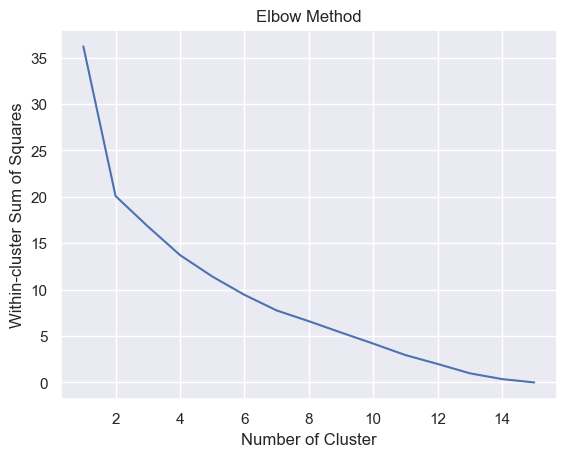

In [117]:
#Extract the returns
returns = all_data[['symbol','return']].copy()
returns['Date'] = returns.index.copy()

pd.options.display.float_format = '{:.4f}'.format

#Pivot the returns to create series of returns for each stock 
transposed = returns.pivot(index = 'Date', columns = 'symbol', values = 'return')

#Transpose the data to get tickers on the index level and dates on the column level since clusters takes place on index level
X = transposed.dropna().transpose()

n_tickers = len(tickers)
#Extract sum of squares for K-means clusters from 1 to 50 clusters
sum_of_sq = np.zeros([n_tickers, 1])
for k in range(1, n_tickers+1):
    sum_of_sq[k-1] = KMeans(n_clusters=k).fit(X).inertia_
    
plt.plot(range(1, n_tickers), sum_of_sq[1:n_tickers])
plt.title("Elbow Method") 
plt.xlabel("Number of Cluster") 
plt.ylabel("Within-cluster Sum of Squares")

pd.DataFrame(sum_of_sq, columns = ['Difference in SS'], index = range(1,n_tickers+1)).diff()

# Num of clusters --> 7

Using the elbow method above, we will choose the number of clusters to be = 7

In [148]:
%%time

# Define the number of clusters
num_clusters = 7

# Function to fit GMM and predict clusters
def fit_predict_gmm(data):
    gmm = GaussianMixture(n_components=num_clusters)
    gmm.fit(data.dropna().transpose())
    clusters = gmm.predict(data.dropna().transpose())
    return clusters

# Create a ThreadPoolExecutor to parallelize the GMM fitting and prediction tasks
with ThreadPoolExecutor(max_workers=2) as executor:
    # Submit the tasks
    tasks = [executor.submit(fit_predict_gmm, transposed) for _ in range(1)]  # Adjust max_workers as needed

    # Gather results
    results = [task.result() for task in tasks]

# Create clusters_df and save it as CSV
clusters_df = pd.DataFrame({'Cluster': results[0], 'Tickers': transposed.columns})
clusters_df = clusters_df.sort_values(['Cluster']).reset_index(drop=True)
clusters_df.to_csv("clusters.csv")

# Read the saved CSV if needed
clusters_df = pd.read_csv("clusters.csv", index_col=0)
print(clusters_df)


    Cluster    Tickers
0         0    SOL-USD
1         1    UNI-USD
2         2    DOT-USD
3         3   DOGE-USD
4         4   AAVE-USD
5         4    ADA-USD
6         4    BNB-USD
7         4    BTC-USD
8         4    EOS-USD
9         4    ETH-USD
10        4    LTC-USD
11        4  MATIC-USD
12        4    TRX-USD
13        4    XMR-USD
14        5    CRV-USD
15        6    DAI-USD
CPU times: user 1.41 s, sys: 823 ms, total: 2.24 s
Wall time: 1.41 s


In [119]:
all_dates = all_data.index.unique().sort_values()
split = round(len(all_dates) * 0.8)
print('Train test split date', str(all_dates[split]))
all_data.index = pd.to_datetime(all_data.index)

train_data = all_data.loc[:str(all_dates[split]),]
test_data = all_data.loc[str(all_dates[split+1]):] 
print(train_data)
print(test_data)

Train test split date 2023-02-11 00:00:00
                Open      High       Low     Close  Adj Close       Volume  \
Date                                                                         
2020-01-30 9316.0166 9553.1260 9230.8975 9508.9932  9508.9932  32378792851   
2020-01-31 9508.3135 9521.7061 9230.7764 9350.5293  9350.5293  29432489719   
2020-02-01 9346.3574 9439.3232 9313.2393 9392.8750  9392.8750  25922656496   
2020-02-02 9389.8203 9468.7979 9217.8242 9344.3652  9344.3652  30835736946   
2020-02-03 9344.6836 9540.3721 9248.6338 9293.5215  9293.5215  30934096509   
...              ...       ...       ...       ...        ...          ...   
2023-02-07 1616.0096 1673.7979 1614.8630 1672.0035  1672.0035   8030277434   
2023-02-08 1671.9053 1688.5272 1635.2650 1650.7168  1650.7168   7806089579   
2023-02-09 1651.0823 1655.2349 1537.1823 1546.4382  1546.4382  10524969124   
2023-02-10 1546.5966 1553.3257 1504.8345 1514.8691  1514.8691   8397387897   
2023-02-11 1514.9419 1

Text(0.5, 1.0, 'Validation Curve Score for n_estimators')

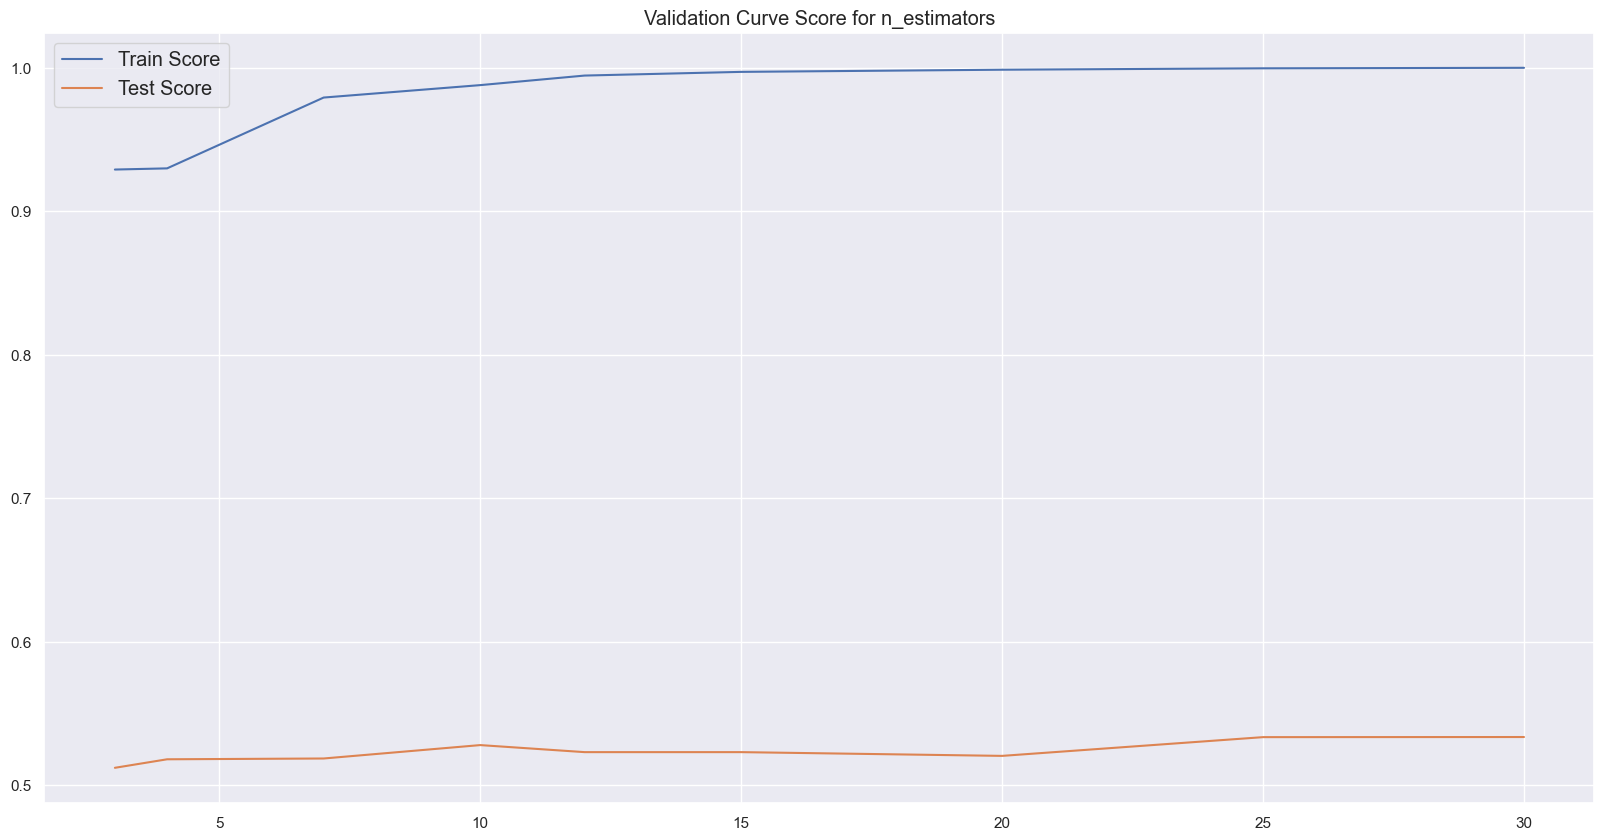

In [121]:
#Separate between X and Y
X_train = train_data.loc[:,Target_variables]

Y_train = train_data.loc[:,['Target_Direction']]

start_date

#Create validation curve for the Random Forest Classifier
rf = RandomForestClassifier()
train_scoreNum, test_scoreNum = validation_curve(rf,
                                X = X_train[start_date:], y = Y_train.loc[start_date:,'Target_Direction'], 
                                param_name = 'n_estimators', 
                                param_range = [3,4,7,10,12,15,20,25,30], cv = TimeSeriesSplit(n_splits = 3))

train_scores_mean = np.mean(train_scoreNum, axis=1)
train_scores_std = np.std(train_scoreNum, axis=1)
test_scores_mean = np.mean(test_scoreNum, axis=1)
test_scores_std = np.std(test_scoreNum, axis=1)

plt.figure(figsize = (20,10))
plt.plot([3,4,7,10,12,15,20,25,30],train_scores_mean)
plt.plot([3,4,7,10,12,15,20,25,30],test_scores_mean)
plt.legend(['Train Score','Test Score'], fontsize = 'large')
plt.title('Validation Curve Score for n_estimators', fontsize = 'large')

In [122]:
#Run the loop for every unique cluster
for cluster_selected in clusters_df.Cluster.unique():
    
    print(f'The current cluster running is : {cluster_selected}')
    
    #Get data for that cluster
    co_data = all_data[all_data.symbol.isin(clusters_df.loc[clusters_df.Cluster==cluster_selected,'Tickers'].tolist())].copy()
    co_train = co_data[:str(all_dates[split])]
    co_train = co_train.dropna().copy()
    
    X_train = co_train.loc[:,Target_variables]

    Y_train = co_train.loc[:,['Target_Direction']]
    Y_train = Y_train['Target_Direction']

    #Define paramters from Validation Curve
    params = {'max_depth': [5, 7],
          'max_features': ['sqrt'],
          'min_samples_leaf': [10, 15, 20],
          'n_estimators': [5, 7, 9],
         'min_samples_split':[20, 25, 30]} #Using Validation Curves

    rf = RandomForestClassifier()

    #Perform a TimeSeriesSplit on the dataset
    time_series_split = TimeSeriesSplit(n_splits = 3)

    
    rf_cv = GridSearchCV(rf, params, cv = time_series_split, n_jobs = -1, verbose = 20)

    #Fit the random forest with our X_train and Y_train
    rf_cv.fit(X_train, Y_train)
          
    #Save the fited variable into a Pickle file
    file_loc = f'{os.getcwd()}\\Pickle_Files\\Cluster_{cluster_selected}'    
    pickle.dump(rf_cv, open(file_loc,'wb'))

The current cluster running is : 0
Fitting 3 folds for each of 54 candidates, totalling 162 fits
The current cluster running is : 1
Fitting 3 folds for each of 54 candidates, totalling 162 fits
The current cluster running is : 2
Fitting 3 folds for each of 54 candidates, totalling 162 fits
The current cluster running is : 3
Fitting 3 folds for each of 54 candidates, totalling 162 fits
The current cluster running is : 4
Fitting 3 folds for each of 54 candidates, totalling 162 fits
The current cluster running is : 5
Fitting 3 folds for each of 54 candidates, totalling 162 fits
The current cluster running is : 6
Fitting 3 folds for each of 54 candidates, totalling 162 fits


In [123]:
#Use second day after split

today_date = all_dates[split+2]
day_data = test_data.loc[today_date]

pred_for_tomorrow = pd.DataFrame({'Date':[],
                                  'ticker':[],
                                  'prediction':[]})

#Predict each stock using the 2nd January Data
for cluster_selected in clusters_df.Cluster.unique():
    rf_cv =  pickle.load(open(os.getcwd() + f'\\Pickle_Files\\Cluster_{cluster_selected}', 'rb'))
    best_rf = rf_cv.best_estimator_
    cluster_data = day_data.loc[day_data.symbol.isin(clusters_df.loc[clusters_df.Cluster==cluster_selected,'Tickers'].tolist())].copy()
    cluster_data = cluster_data.dropna()
    if (cluster_data.shape[0]>0):
        X_test = cluster_data.loc[:,Target_variables]

        new_data = pd.DataFrame({'Date': cluster_data.index,
                         'ticker': cluster_data['symbol'],
                         'prediction': best_rf.predict_proba(X_test)[:, 1]})

        pred_for_tomorrow = pd.concat([pred_for_tomorrow, new_data], ignore_index=True)

top_10_pred = pred_for_tomorrow.sort_values(by=['prediction'], ascending=False).head(10)

for selected_ticker in top_10_pred['ticker']:
    actual = all_data[all_data.symbol == selected_ticker].loc[today_date, 'Target_Direction']
    pct_change = all_data[all_data.symbol == selected_ticker].loc[today_date, 'Target']
    top_10_pred.loc[top_10_pred.ticker == selected_ticker, 'actual'] = actual
    top_10_pred.loc[top_10_pred.ticker == selected_ticker, 'pct_change'] = pct_change

top_10_pred

,Date,ticker,prediction,actual,pct_change
2,2023-02-13,BTC-USD,0.6390,1.0000,13.8857
12,2023-02-13,DOGE-USD,0.6082,1.0000,7.3835
1,2023-02-13,UNI-USD,0.6073,1.0000,309.5041
6,2023-02-13,SOL-USD,0.5747,1.0000,25.9835
13,2023-02-13,CRV-USD,0.5631,1.0000,20.1964
10,2023-02-13,MATIC-USD,0.5585,1.0000,24.2634
15,2023-02-13,BNB-USD,0.5549,1.0000,7.0999
8,2023-02-13,ADA-USD,0.5545,1.0000,12.3569
11,2023-02-13,ETH-USD,0.5534,1.0000,12.9850
7,2023-02-13,TRX-USD,0.5398,1.0000,9.6680


2023-02-14 00:00:00 to 2023-02-21 00:00:00
BTC-USD
DOGE-USD
UNI-USD
SOL-USD
CRV-USD
MATIC-USD
BNB-USD
ADA-USD
ETH-USD
TRX-USD


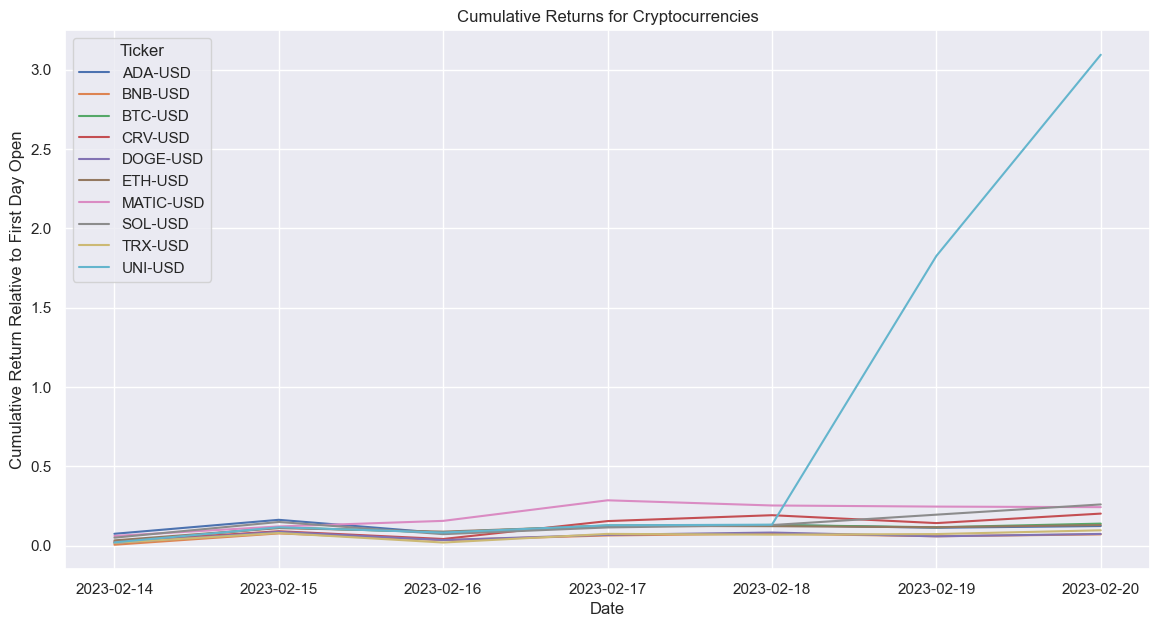

In [124]:
# for each of the tickers above, i want to get the open and close price for the next seven days

check_price = pd.DataFrame()

print(today_date + dt.timedelta(days=1), 'to', today_date + dt.timedelta(days=8))

for selected_ticker in top_10_pred['ticker']:
    print(selected_ticker)
    actual = all_data[(all_data.symbol == selected_ticker) & 
                      (all_data.index >= today_date + dt.timedelta(days=1))& 
                      (all_data.index < today_date + dt.timedelta(days=8))]
    check_price = pd.concat([check_price,actual])
    
#check_price.tail(7)

df = check_price[['Open','Close','symbol']].copy()
df['Date'] = df.index

# Now, proceed with the cumulative return calculation
# Calculate the cumulative return based on the close price of each day minus the open price on day 1
df['first_day_open'] = df.groupby('symbol')['Open'].transform('first')
df['cumulative_return'] = (df['Close'] - df['first_day_open']) / df['first_day_open']

# Since transform keeps the original index, there's no need to reset the index, so we can directly pivot
pivot_df = df.pivot(columns='symbol', values='cumulative_return')

# Plotting
plt.figure(figsize=(14, 7))
for column in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[column], label=column)

plt.xlabel('Date')
plt.ylabel('Cumulative Return Relative to First Day Open')
plt.title('Cumulative Returns for Cryptocurrencies')
plt.legend(title='Ticker')
plt.show()

# We rinse and repeat and check for potential tickers to buy

2023-02-14 00:00:00 to 2023-02-21 00:00:00
MATIC-USD
DOT-USD
BTC-USD
XMR-USD
LTC-USD
SOL-USD
DOGE-USD
UNI-USD
DAI-USD
ETH-USD


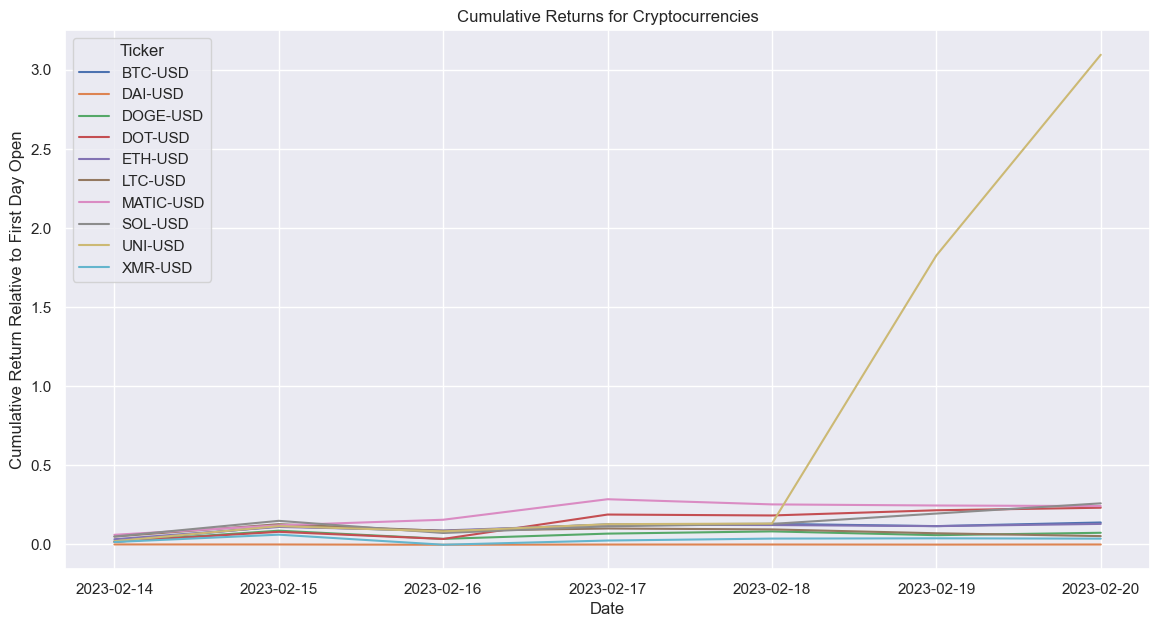

2023-02-21 00:00:00 to 2023-02-28 00:00:00
DOT-USD
XMR-USD
TRX-USD
EOS-USD
BTC-USD
LTC-USD
DOGE-USD
MATIC-USD
CRV-USD
SOL-USD


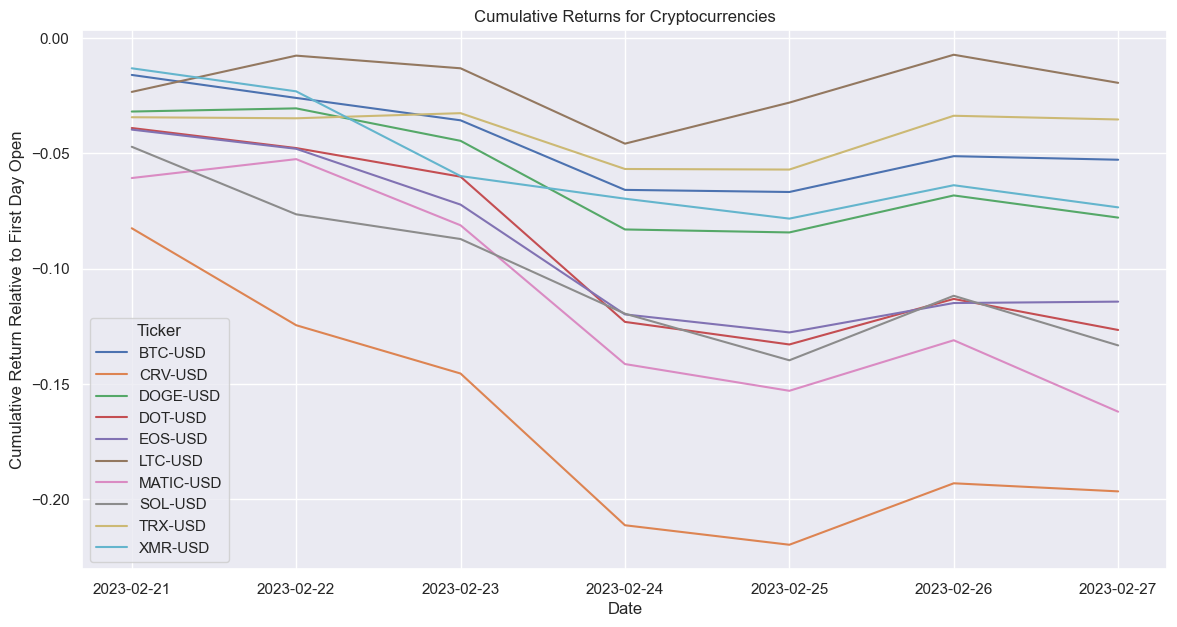

2023-02-28 00:00:00 to 2023-03-07 00:00:00
XMR-USD
TRX-USD
MATIC-USD
EOS-USD
DOT-USD
CRV-USD
DOGE-USD
DAI-USD
BNB-USD
BTC-USD


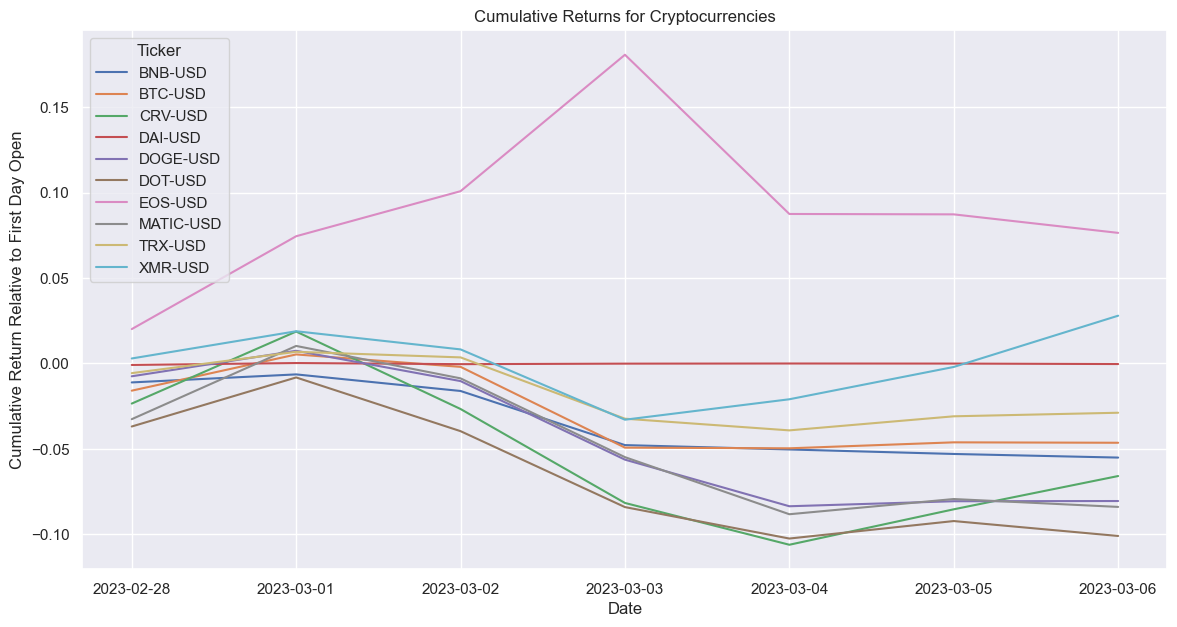

2023-03-07 00:00:00 to 2023-03-14 00:00:00
DOGE-USD
BNB-USD
SOL-USD
DAI-USD
XMR-USD
CRV-USD
UNI-USD
DOT-USD
ADA-USD
MATIC-USD


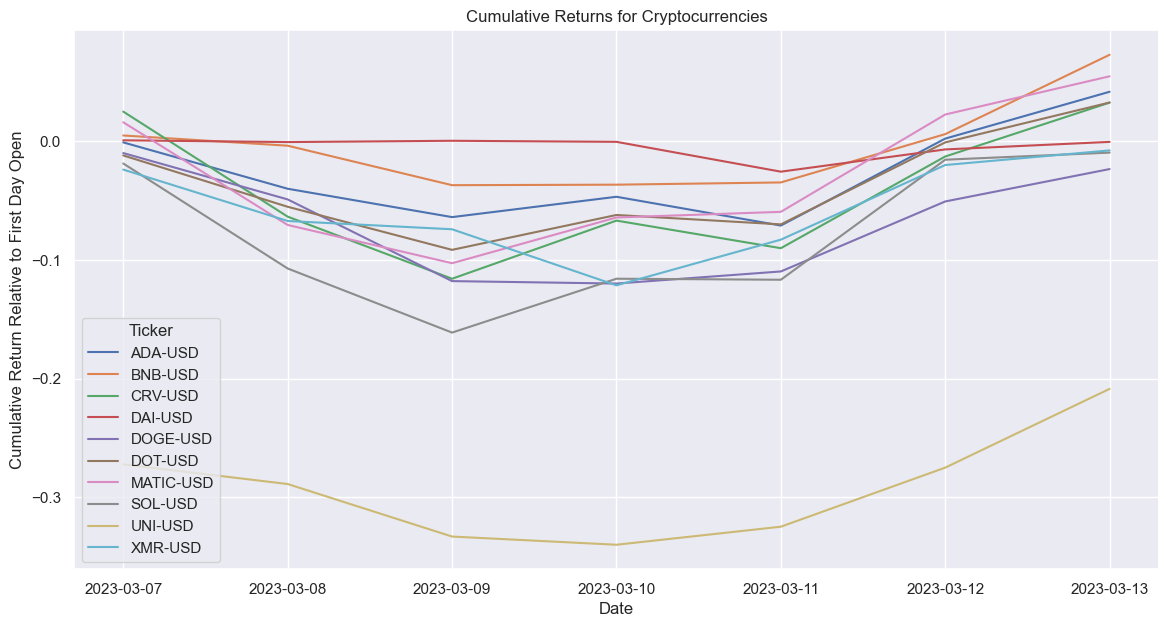

2023-03-14 00:00:00 to 2023-03-21 00:00:00
DAI-USD
BTC-USD
ETH-USD
BNB-USD
SOL-USD
ADA-USD
DOGE-USD
TRX-USD
EOS-USD
LTC-USD


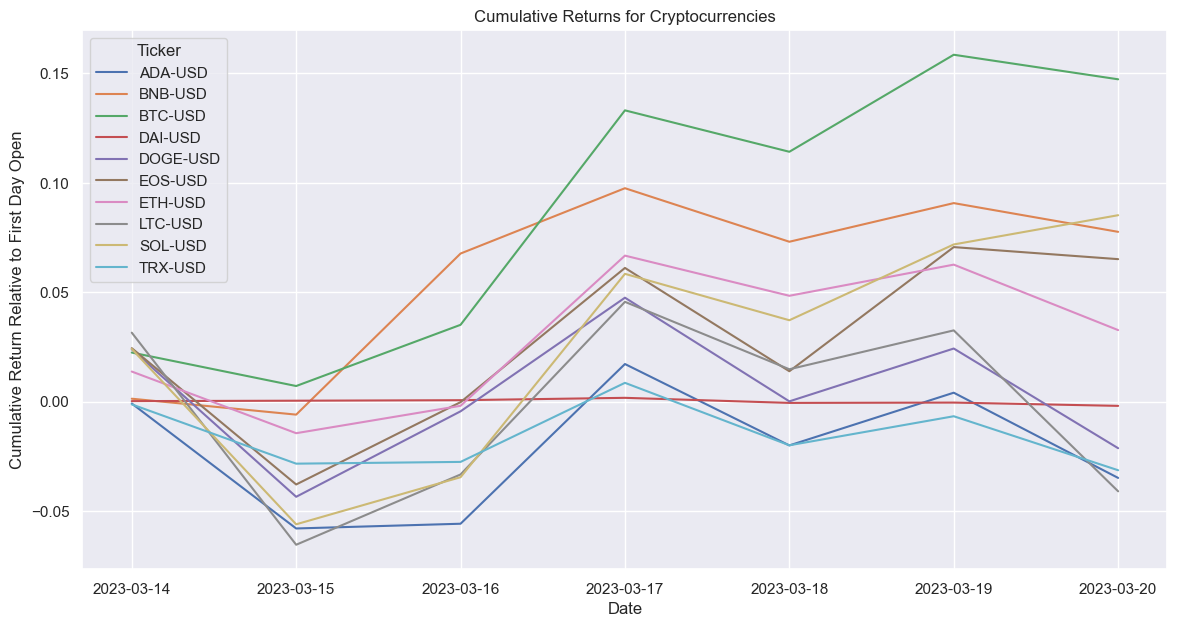

2023-03-21 00:00:00 to 2023-03-28 00:00:00
DAI-USD
DOGE-USD
BNB-USD
EOS-USD
BTC-USD
ETH-USD
CRV-USD
SOL-USD
ADA-USD
LTC-USD


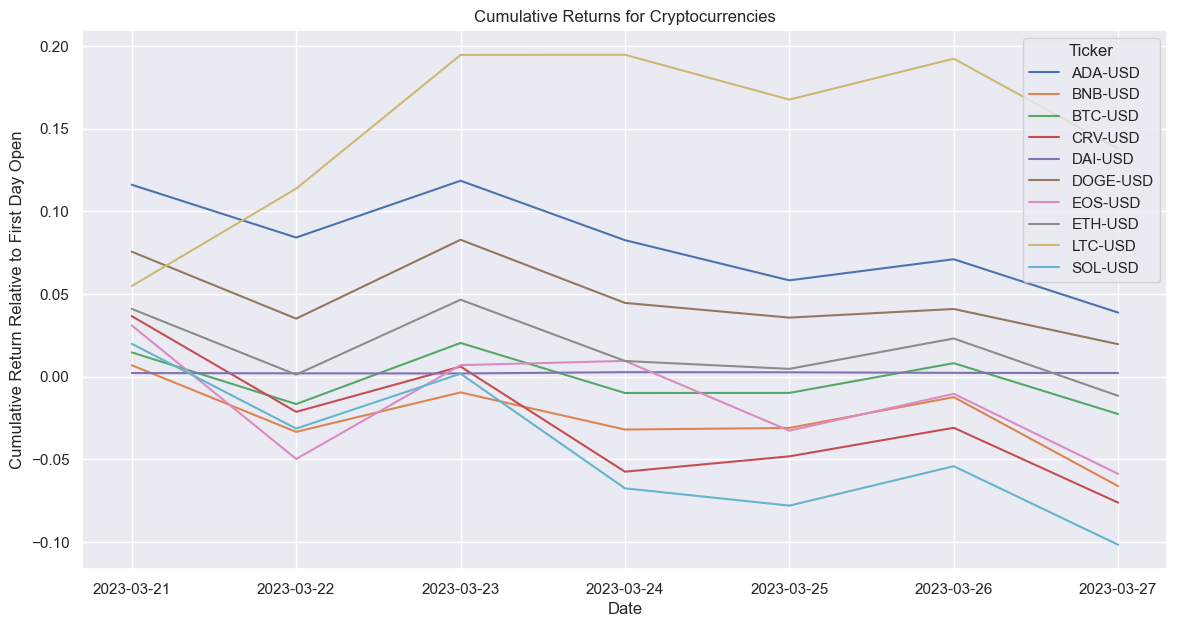

2023-03-28 00:00:00 to 2023-04-04 00:00:00
DAI-USD
LTC-USD
MATIC-USD
BTC-USD
DOT-USD
SOL-USD
ETH-USD
XMR-USD
TRX-USD
DOGE-USD


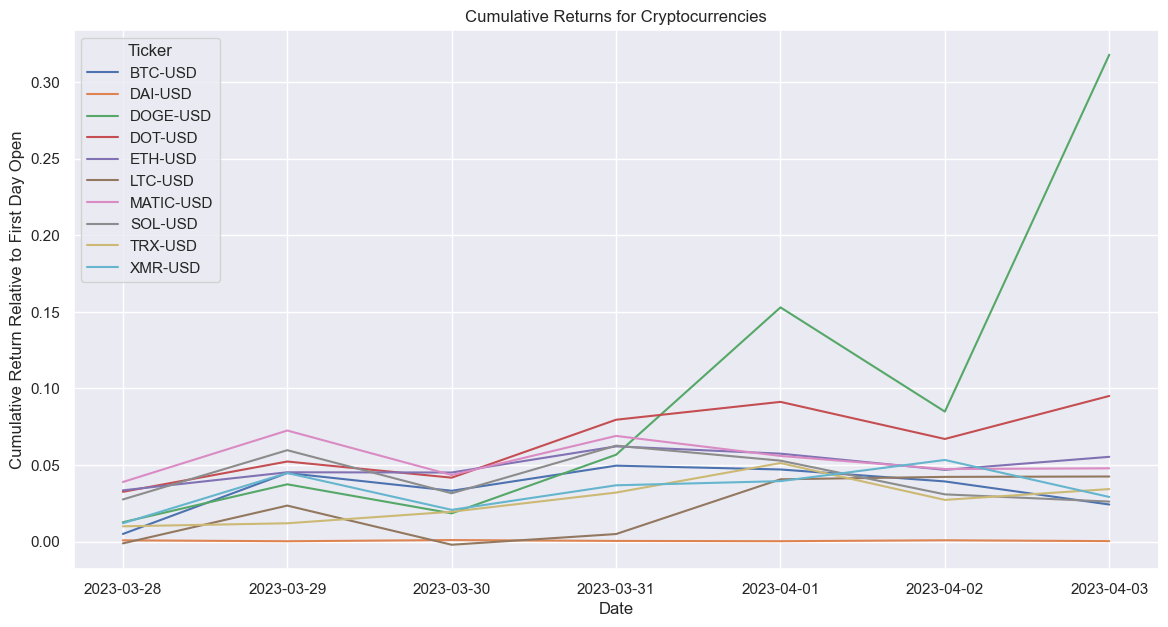

2023-04-04 00:00:00 to 2023-04-11 00:00:00
SOL-USD
MATIC-USD
DAI-USD
UNI-USD
DOGE-USD
XMR-USD
EOS-USD
DOT-USD
BTC-USD
TRX-USD


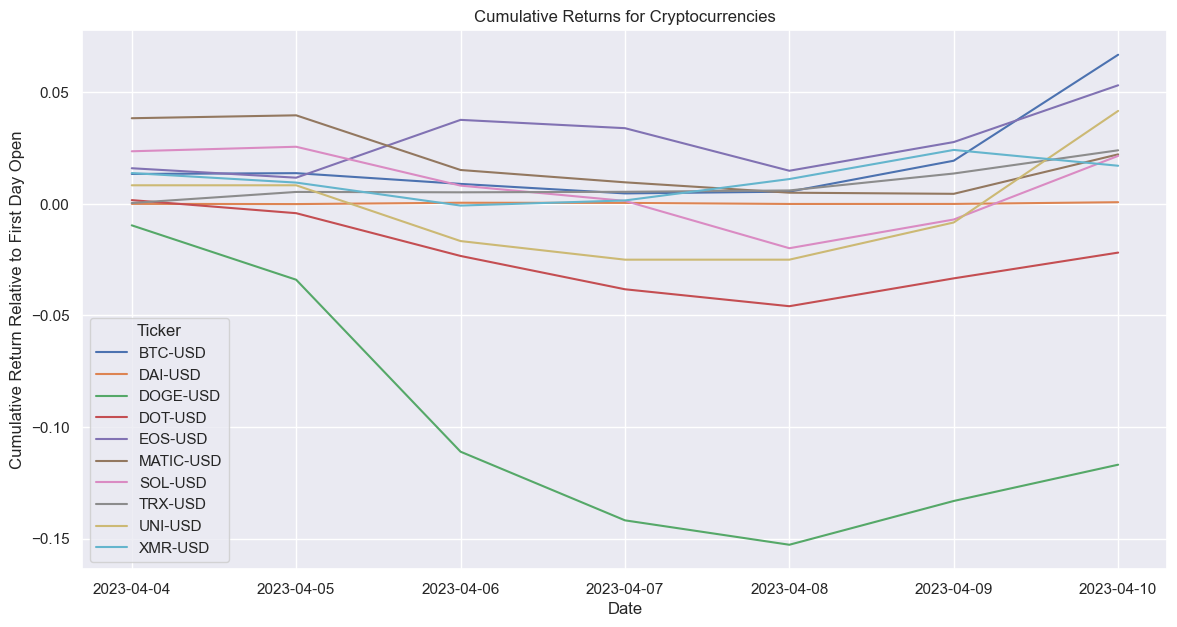

In [163]:
capital = 100000
num_stocks = 10
portfolio_returns = []

for i in range(0,8):
    #Use second day after split
    allocated_each = capital / num_stocks
    today_date = all_dates[split+2+i*7]
    day_data = test_data.loc[today_date]

    pred_for_tomorrow = pd.DataFrame({'Date':[],
                                      'ticker':[],
                                      'prediction':[]})

    #Predict each stock using the 2nd January Data
    for cluster_selected in clusters_df.Cluster.unique():
        rf_cv =  pickle.load(open(os.getcwd() + f'\\Pickle_Files\\Cluster_{cluster_selected}', 'rb'))
        best_rf = rf_cv.best_estimator_
        cluster_data = day_data.loc[day_data.symbol.isin(clusters_df.loc[clusters_df.Cluster==cluster_selected,'Tickers'].tolist())].copy()
        cluster_data = cluster_data.dropna()
        if (cluster_data.shape[0]>0):
            X_test = cluster_data.loc[:,Target_variables]

            new_data = pd.DataFrame({'Date': cluster_data.index,
                             'ticker': cluster_data['symbol'],
                             'prediction': best_rf.predict_proba(X_test)[:, 1]})

            pred_for_tomorrow = pd.concat([pred_for_tomorrow, new_data], ignore_index=True)

    top_10_pred = pred_for_tomorrow.sort_values(by=['prediction'], ascending=False).head(10)

    for selected_ticker in top_10_pred['ticker']:
        actual = all_data[all_data.symbol == selected_ticker].loc[today_date, 'Target_Direction']
        pct_change = all_data[all_data.symbol == selected_ticker].loc[today_date, 'Target']
        top_10_pred.loc[top_10_pred.ticker == selected_ticker, 'actual'] = actual
        top_10_pred.loc[top_10_pred.ticker == selected_ticker, 'pct_change'] = pct_change

    top_10_pred
    
    # for each of the tickers above, i want to get the open and close price for the next seven days

    check_price = pd.DataFrame()

    print(today_date + dt.timedelta(days=1), 'to', today_date + dt.timedelta(days=8))

    for selected_ticker in top_10_pred['ticker']:
        print(selected_ticker)
        actual = all_data[(all_data.symbol == selected_ticker) & 
                          (all_data.index >= today_date + dt.timedelta(days=1))& 
                          (all_data.index < today_date + dt.timedelta(days=8))]
        check_price = pd.concat([check_price,actual])

    #check_price.tail(7)

    df = check_price[['Open','Close','symbol']].copy()
    df['Date'] = df.index

    # Now, proceed with the cumulative return calculation
    # Calculate the cumulative return based on the close price of each day minus the open price on day 1
    df['first_day_open'] = df.groupby('symbol')['Open'].transform('first')
    df['cumulative_return'] = (df['Close'] - df['first_day_open']) / df['first_day_open']

    # Since transform keeps the original index, there's no need to reset the index, so we can directly pivot
    pivot_df = df.pivot(columns='symbol', values='cumulative_return')

    # Plotting
    plt.figure(figsize=(14, 7))
    for column in pivot_df.columns:
        plt.plot(pivot_df.index, pivot_df[column], label=column)

    plt.xlabel('Date')
    plt.ylabel('Cumulative Return Relative to First Day Open')
    plt.title('Cumulative Returns for Cryptocurrencies')
    plt.legend(title='Ticker')
    plt.show()
    
    allocated_each = capital / num_stocks

    weekly_gains = df.groupby('symbol').last().reset_index()
    ticker_gains = (allocated_each/weekly_gains['first_day_open']) * (weekly_gains['Close'] - weekly_gains['first_day_open'])
    ticker_gains_alternate = -0.1 * weekly_gains['first_day_open'] # basic 10% stop loss
    ticker_gains = np.maximum(ticker_gains, ticker_gains_alternate)
    capital *= 0.99 # 1% fee
    capital += ticker_gains.sum()
    portfolio_returns.append(ticker_gains.sum() - capital * 0.01)


In [164]:
print('Final capital',capital)

portfolio_returns = np.array(portfolio_returns)
print(portfolio_returns)

risk_free_rate = 0

# Calculate downside returns (returns below the risk-free rate)
downside_returns = np.minimum(portfolio_returns - risk_free_rate, 0)

# Calculate downside standard deviation
downside_std_dev = np.std(downside_returns)

# Calculate Sortino Ratio
sortino_ratio = (np.mean(portfolio_returns) - risk_free_rate) / downside_std_dev

# Calculate portfolio standard deviation
portfolio_std_dev = np.std(portfolio_returns)

# Calculate Sharpe Ratio
sharpe_ratio = (np.mean(portfolio_returns) - risk_free_rate) / portfolio_std_dev

print(sortino_ratio)
print(sharpe_ratio)


Final capital 156489.2974289552
[41201.12628478 -2170.96292679  -610.01858485  1815.75064907
  4281.65447073   885.87449542  8274.1851979   2246.79486841]
9.74290343723639
0.5270074106708049
